In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


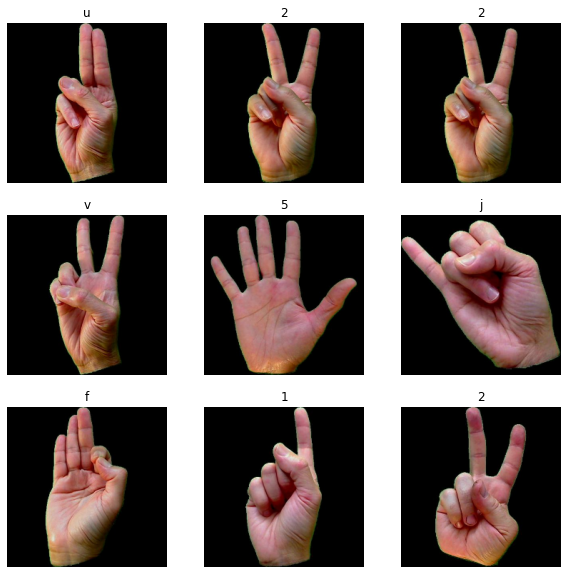

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation


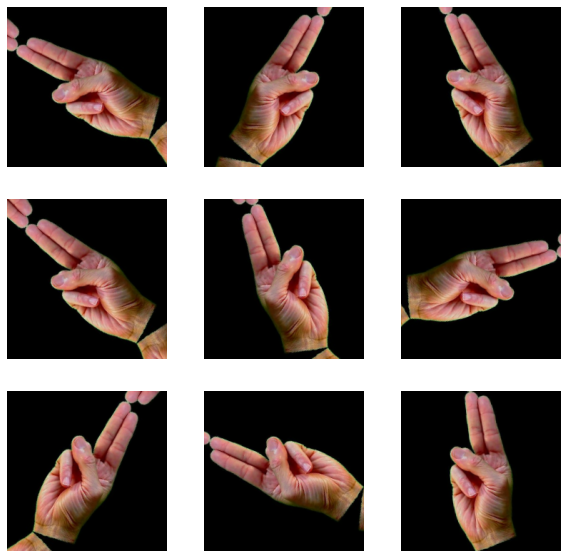

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg19.VGG19(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet',classes= 1000, classifier_activation='softmax')

574726144/574710816 [==============================] - 6s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

fc2
predictions


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n02786058', 'Band_Aid', 0.118377216), ('n03929660', 'pick', 0.044960566)],
 [('n03929660', 'pick', 0.20960426), ('n02786058', 'Band_Aid', 0.13098586)],
 [('n02786058', 'Band_Aid', 0.38272354), ('n03929660', 'pick', 0.10136215)],
 [('n02786058', 'Band_Aid', 0.48371938),
  ('n03729826', 'matchstick', 0.22467233)],
 [('n02786058', 'Band_Aid', 0.24102162),
  ('n01910747', 'jellyfish', 0.15014793)],
 [('n02786058', 'Band_Aid', 0.16188127), ('n03929660', 'pick', 0.158201)],
 [('n02786058', 'Band_Aid', 0.45451614), ('n03929660', 'pick', 0.08503047)],
 [('n02786058', 'Band_Aid', 0.8301658),
  ('n03729826', 'matchstick', 0.029598117)],
 [('n02786058', 'Band_Aid', 0.17148891), ('n03929660', 'pick', 0.11384944)],
 [('n03729826', 'matchstick', 0.27544674),
  ('n02786058', 'Band_Aid', 0.23877451)],
 [('n02786058', 'Band_Aid', 0.6660674), ('n03929660', 'pick', 0.1307194)],
 [('n03729826', 'matchstick', 0.20003784),
  ('n02786058', 'Band_Aid', 0.1290581)],
 [('n02786058', 'Band_Aid', 0.833919), (

In [ ]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.vgg19.VGG19(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet', classes=26, classifier_activation='softmax') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False) 
  x = tfl.Dense(4096)(x)
  x = tfl.Dense(128)(x)
  # x = tfl.Dropout(0.2)(x)
  x = tfl.GlobalAveragePooling2D()(x)
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model


In [ ]:
model = asl_model(IMG_SIZE, data_augmentation)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dense (Dense)               (None, 7, 7, 4096)        2101248   
                                                             

In [ ]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
initial_epochs = 50
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 770s 14s/step - loss: 8.1218 - accuracy: 0.3106 - val_loss: 3.3561 - val_accuracy: 0.4549
Epoch 2/50
56/56 [==============================] - 16s 278ms/step - loss: 2.5167 - accuracy: 0.5945 - val_loss: 1.8582 - val_accuracy: 0.6074
Epoch 3/50
56/56 [==============================] - 16s 285ms/step - loss: 1.1751 - accuracy: 0.7161 - val_loss: 1.2978 - val_accuracy: 0.6870
Epoch 4/50
56/56 [==============================] - 17s 291ms/step - loss: 0.9143 - accuracy: 0.7712 - val_loss: 1.9262 - val_accuracy: 0.6499
Epoch 5/50
56/56 [==============================] - 17s 292ms/step - loss: 1.6550 - accuracy: 0.7195 - val_loss: 1.4087 - val_accuracy: 0.6870
Epoch 6/50
56/56 [==============================] - 17s 295ms/step - loss: 0.7052 - accuracy: 0.8251 - val_loss: 1.7486 - val_accuracy: 0.6764
Epoch 7/50
56/56 [==============================] - 16s 284ms/step - loss: 0.7993 - accuracy: 0.8137 - val_loss: 2.3738 - val_accuracy: 0.6273


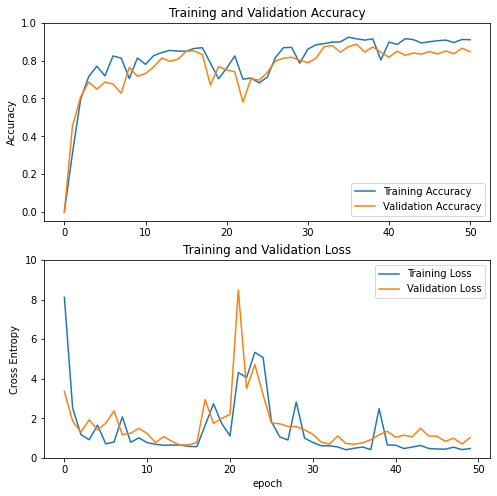

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()